# Présentation du TP4 : Classification avec un MLP

## 1. Introduction
Ce projet met en œuvre un réseau de neurones multi-couches (MLP) pour la classification de données synthétiques.  
Le modèle est entraîné sur un jeu de données de 10 000 exemples avec 10 caractéristiques et 4 classes.

## Hyperparamètres du modèle :
- **Nombre d’époques** : 80
- **Taux d’apprentissage** : 0.01
- **Taille du batch** : 32
- **Nombre de neurones cachés** : 32
- **Dropout** : 10%

L'objectif est d'entraîner ce modèle et d'analyser ses performances.


## 2. Chargement des données et Visualisation

Shape de X: (10000, 10)
Shape de y: (10000,)


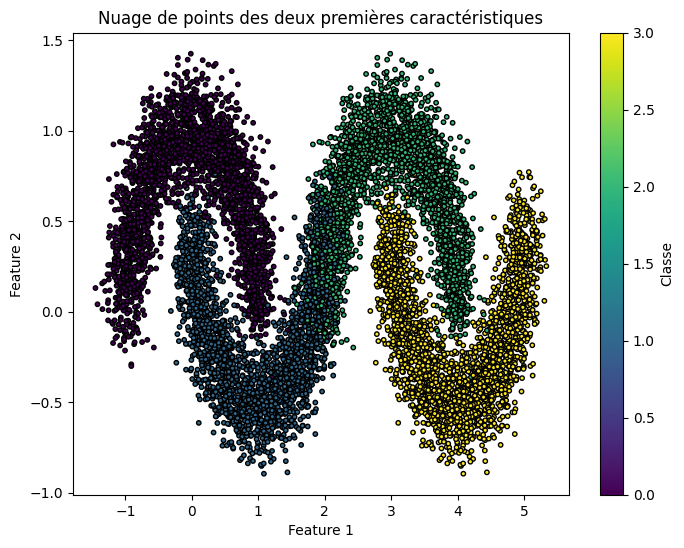

In [26]:
# 2. Chargement des Données et Visualisation Initiale
import numpy as np
import pickle
import matplotlib.pyplot as plt
import time


# Chargement des données
def load_data(filename):
    with open(filename, "rb") as f:
        X, y = pickle.load(f)
    return X, y


def softmax(logits):
    exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)


X, y = load_data("tp4_data.pkl")



# Affichage des dimensions des données
print(f"Shape de X: {X.shape}")  # Devrait être (10000, 10)
print(f"Shape de y: {y.shape}")  # Devrait être (10000,)

# Affichage des 2 premières dimensions
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis", edgecolor="k", s=10)
plt.colorbar(scatter, label="Classe")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Nuage de points des deux premières caractéristiques")
plt.show()


## 3. Préparation des données et vérification des gradients

In [27]:
# 3. Préparation des Données
# Mélange et séparation des données
num_samples = X.shape[0]
np.random.seed(42)
indices = np.random.permutation(num_samples)

test_size = int(0.1 * num_samples)
val_size = int(0.2 * num_samples)

test_idx = indices[:test_size]
val_idx = indices[test_size:test_size + val_size]
train_idx = indices[test_size + val_size:]

Xtest, ytest = X[test_idx], y[test_idx]
Xval, yval = X[val_idx], y[val_idx]
Xtrain, ytrain = X[train_idx], y[train_idx]

print(f"Taille du train set : {Xtrain.shape[0]}")
print(f"Taille du validation set : {Xval.shape[0]}")
print(f"Taille du test set : {Xtest.shape[0]}")


Taille du train set : 7000
Taille du validation set : 2000
Taille du test set : 1000


In [28]:
# 4. Définition du Modèle
class ReLU:
    def __init__(self):
        self.input = None  # Stocker l'entrée pour la passe arrière

    def forward(self, x):
        self.input = x  # Sauvegarde de l'entrée pour l'utiliser en backward
        return np.maximum(0, x)

    def backward(self, grad_out):
        return grad_out * (self.input > 0)  # Utilisation de self.input au lieu de x
    
    def step(self, lr):
        pass


class Linear:
    def __init__(self, n_in, n_out):
        np.random.seed(42)
        self.W = np.random.randn(n_in, n_out) * np.sqrt(2 / n_in)
        self.b = np.zeros(n_out)

    def forward(self, x):
        self.x_cache = x
        return x @ self.W + self.b

    def backward(self, grad_out):
        self.grad_W = self.x_cache.T @ grad_out / len(self.x_cache)
        self.grad_b = np.mean(grad_out, axis=0)
        return grad_out @ self.W.T

    def step(self, lr):
        self.W -= lr * self.grad_W
        self.b -= lr * self.grad_b

class Dropout:
    def __init__(self, dropout):
        self.dropout = dropout
        self.inference = False

    def forward(self, x):
        if self.inference:
            return x
        np.random.seed(42)
        self.mask = np.random.binomial(1, 1 - self.dropout, size=x.shape)
        return x * self.mask

    def backward(self, grad_out):
        return grad_out * self.mask

    def step(self, lr):
        pass


# Sequential 
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x) 
        return x

    def backward(self, out_grad):
        for layer in reversed(self.layers):  
            out_grad = layer.backward(out_grad) 
        return out_grad 

    def step(self, lr):
        for layer in self.layers:
            layer.step(lr)
    
    def inference_mode(self, setting):
        for layer in self.layers:
            if hasattr(layer, "inference"):
                layer.inference = setting

   

class Dropout:
    def __init__(self, dropout):
        self.dropout = dropout
        self.inference = False

    def forward(self, x):
        if self.inference:
            return x
        else:
            np.random.seed(42)
            mask = np.random.binomial(1, 1 - self.dropout, size=x.shape)
            self.mask = mask
            return x * mask

    def backward(self, grad_out):
        if self.inference:
            return grad_out 
        else:
            return grad_out * self.mask 
    
    def step(self, lr):
        pass


class MLPClassifier:
    def __init__(self, in_features, hidden_features, num_classes, dropout, lr):
        self.net = Sequential(
            [
                Linear(in_features, hidden_features),
                Dropout(dropout),
                ReLU(),
                Linear(hidden_features, num_classes),
            ]
        )
        self.lr = lr
        self.num_classes = num_classes

    def forward(self, x):
        self.logits = self.net.forward(x)
        self.probs = softmax(self.logits)
        return self.probs

    def loss(self, labels):
        self.labels = labels
        correct_probs = self.probs[np.arange(len(labels)), labels]
        return np.mean(-np.log(correct_probs))

    @staticmethod
    def one_hot(labels, num_classes):
        Y = np.zeros((len(labels), num_classes))
        Y[np.arange(len(labels)), labels] = 1
        return Y


    def backward(self):
        loss_grad = self.probs - self.one_hot(self.labels, self.num_classes)
        return self.net.backward(loss_grad)

    def step(self):
        self.net.step(self.lr)

    def predict(self, data):
        self.net.inference_mode(True)
        probs = self.net.forward(data)
        self.net.inference_mode(False)
        return np.argmax(probs, axis=1)

    def validate(self, data, labels):
        preds = self.predict(data)
        accuracy = np.mean(preds == labels)
        return accuracy

## 4. Entraînement du modèle

In [29]:
# 5. Entraînement du Modèle
# Hyperparamètres:
num_epochs = 120
lr = 0.01
batch_size = 32
dropout_rate = 0.1
hidden_features = 32

net = MLPClassifier(10, hidden_features, 4, dropout_rate, lr)

train_losses = []
val_accuracies = []
epoch_times = []

for epoch in range(num_epochs):
    start_time = time.time()
    
    np.random.seed(42)
    indices = np.random.permutation(len(Xtrain))
    Xtrain_shuffled = Xtrain[indices]
    ytrain_shuffled = ytrain[indices]

    total_loss = 0
    num_batches = 0

    for i in range(0, len(Xtrain), batch_size):
        X_batch = Xtrain_shuffled[i:i + batch_size]
        y_batch = ytrain_shuffled[i:i + batch_size]

        probs = net.forward(X_batch)
        loss = net.loss(y_batch)
        total_loss += loss
        num_batches += 1

        net.backward()
        net.step()

    avg_loss = total_loss / num_batches
    train_losses.append(avg_loss)

    val_acc = net.validate(Xval, yval)
    val_accuracies.append(val_acc)

    epoch_time = time.time() - start_time
    epoch_times.append(epoch_time)

    print(f"Époque {epoch + 1}/{num_epochs} - Perte : {avg_loss:.4f} - Précision val : {val_acc*100:.2f}% - Temps : {epoch_time:.2f}s")


Époque 1/120 - Perte : 1.3949 - Précision val : 50.25% - Temps : 0.05s
Époque 2/120 - Perte : 0.9833 - Précision val : 64.35% - Temps : 0.02s
Époque 3/120 - Perte : 0.8387 - Précision val : 70.75% - Temps : 0.01s
Époque 4/120 - Perte : 0.7489 - Précision val : 74.75% - Temps : 0.01s
Époque 5/120 - Perte : 0.6808 - Précision val : 77.65% - Temps : 0.01s
Époque 6/120 - Perte : 0.6265 - Précision val : 78.90% - Temps : 0.01s
Époque 7/120 - Perte : 0.5836 - Précision val : 79.70% - Temps : 0.01s
Époque 8/120 - Perte : 0.5501 - Précision val : 80.50% - Temps : 0.01s
Époque 9/120 - Perte : 0.5240 - Précision val : 81.45% - Temps : 0.01s
Époque 10/120 - Perte : 0.5032 - Précision val : 81.60% - Temps : 0.01s
Époque 11/120 - Perte : 0.4866 - Précision val : 81.85% - Temps : 0.01s
Époque 12/120 - Perte : 0.4731 - Précision val : 82.15% - Temps : 0.01s
Époque 13/120 - Perte : 0.4620 - Précision val : 82.55% - Temps : 0.01s
Époque 14/120 - Perte : 0.4526 - Précision val : 82.55% - Temps : 0.01s
É

## 5. Affichage des courbes de perte et de précision

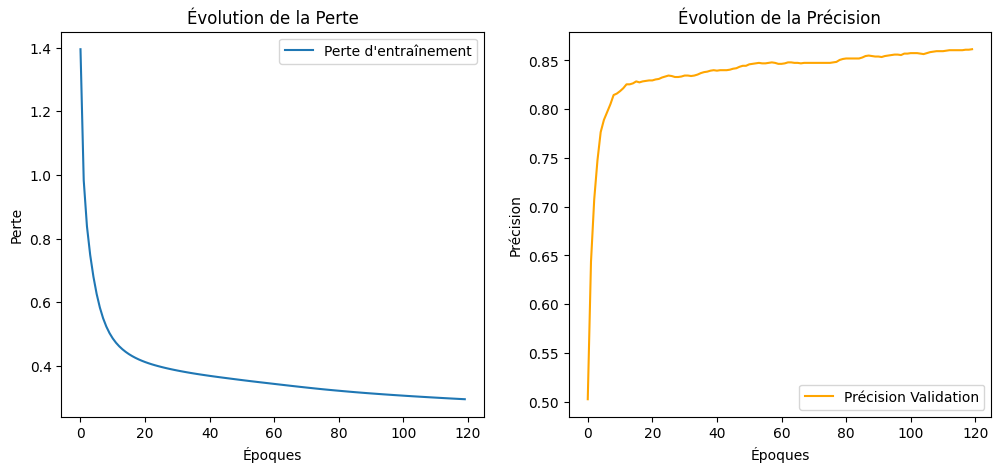

In [30]:
# 6. Courbes de Perte et Précision
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Perte d'entraînement")
plt.xlabel("Époques")
plt.ylabel("Perte")
plt.title("Évolution de la Perte")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Précision Validation", color='orange')
plt.xlabel("Époques")
plt.ylabel("Précision")
plt.title("Évolution de la Précision")
plt.legend()

plt.show()


## 6. Analyse des performances du modèle:

In [31]:
# 7. Analyse des Performances
print(f"Temps moyen par époque : {np.mean(epoch_times):.2f}s")
test_acc = net.validate(Xtest, ytest)
print(f"Précision finale sur le jeu de test : {test_acc*100:.2f}%")


Temps moyen par époque : 0.01s
Précision finale sur le jeu de test : 85.20%


## 7. Visualisation des régions prédites par le modèle

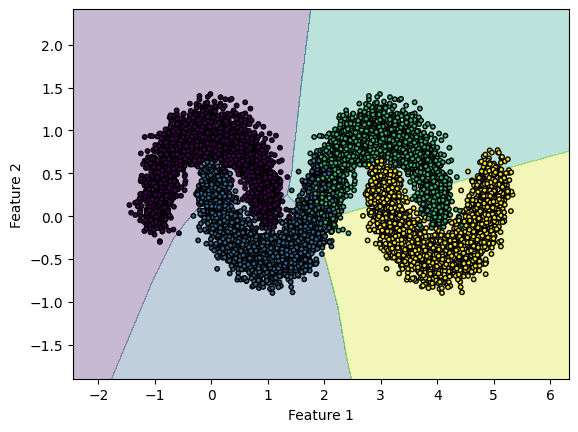

In [32]:

from tp4_starter import plot_decision_boundaries

plot_decision_boundaries(X, y, net)

## 8. Conclusion : Description du modèle et choix des hyperparamètres

Nous avons implémenté un perceptron multicouche (MLP) en NumPy pour un problème de classification.  
Le modèle est composé de :
- **Une couche linéaire** 
- **Une activation ReLU** pour introduire la non-linéarité,
- **Un Dropout (0.1)** pour éviter l'overfitting,
- **Une couche linéaire finale** suivie d'une softmax.

### Choix des hyperparamètres :
- **Taux d’apprentissage** : **0.01**, après plusieurs test, j'ai retenu cette valeur.
- **Nombre d’époques** : **120**, pour une convergence(au début, je l'avais beaucoup augmenté mais je craignais également l'overfitting).
- **Batch size** : **32**, un compromis entre rapidité et stabilité.
- **Taille de la couche cachée (`hidden_features`)** : **32**, un bon équilibre entre expressivité et complexité.

Ce modèle a atteint **85,20% de précision** sur le jeu de test, validant son efficacité.
